# Task 1 : Set up colab gpu runtime environment

In [2]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     |████████████████████████████████| 88 kB 3.3 MB/s 
     |████████████████████████████████| 376 kB 25.4 MB/s 
     |████████████████████████████████| 58 kB 6.6 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=4d459f8f3d505410dbdfe8face74eb020d18ce963f5527a1371a046afab06813
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=5f9f7bfc322cd13d7c3452eef4a0454e3bf5a2103cad446208e8596a0c3f6acd
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-x7he_1ow
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-x7he_1ow
   

# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset 

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

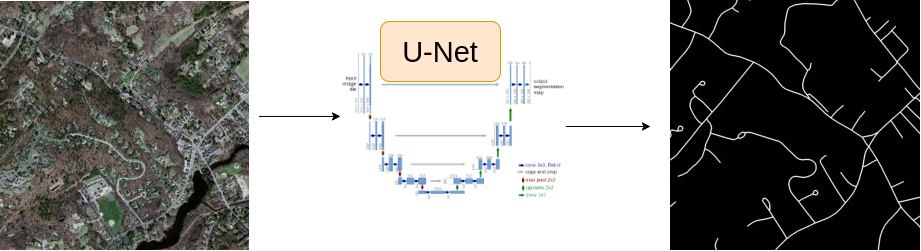

# Download Subset Dataset

In [3]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411
Receiving objects: 100% (411/411), 851.74 MiB | 13.70 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (401/401), done.


# Some Common Imports

In [4]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [5]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [1]:
CSV_FILE = '/content/Road_seg_dataset/train.csv'
DATA_DIR = '/content/Road_seg_dataset/'
DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
BATCH_SIZE = 8
IMG_SIZE = 512

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [7]:
idx = 2
row = df.iloc[idx]
image_path = DATA_DIR + row.images
mask_path = DATA_DIR + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255


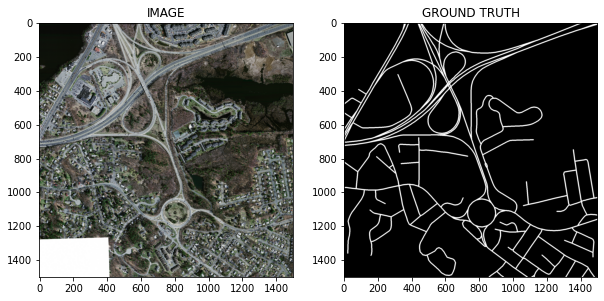

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state = 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [10]:
import albumentations as A

In [11]:
def get_train_augs():
  return A.Compose([
                    A.Resize(IMG_SIZE,IMG_SIZE),
                    A.HorizontalFlip(p = 0.5),
                    A.VerticalFlip(p = 0.5)
  ])

def get_valid_augs():
  return A.Compose([
                    A.Resize(IMG_SIZE,IMG_SIZE)
  ])

# Task 4 : Create Custom Dataset 

In [12]:
from torch.utils.data import Dataset

In [13]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    image_path = DATA_DIR + row.images
    mask_path = DATA_DIR + row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']
    
    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image)/255.0
    mask = torch.round(torch.Tensor(mask)/255.0)

    return image, mask
      
          

In [14]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [15]:
print(f'Size of trainset : {len(trainset)}')
print(f'Size of validset : {len(validset)}')

Size of trainset : 159
Size of validset : 40


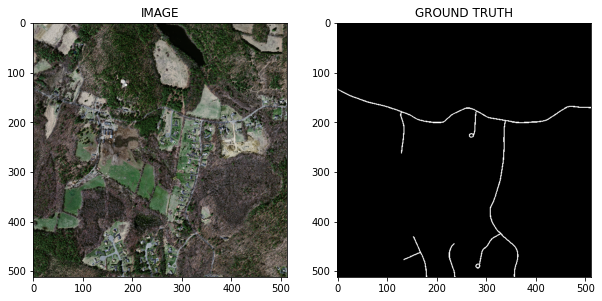

In [16]:
idx = 3

image, mask = trainset[idx]

helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [17]:
from torch.utils.data import DataLoader

In [18]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [19]:
print(f'Total no. of batches in trainloader : {len(trainloader)}')
print(f'Total no. of batches in validloader : {len(validloader)}')

Total no. of batches in trainloader : 20
Total no. of batches in validloader : 5


In [20]:
for images, masks in trainloader:
  print(f'One batch image shape : {images.shape}')
  print(f"One batch mask shape : {masks.shape}")
  break;

One batch image shape : torch.Size([8, 3, 512, 512])
One batch mask shape : torch.Size([8, 1, 512, 512])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [22]:
import segmentation_models_pytorch as smp 
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn

In [23]:
class SegmentationModel(nn.Module):

  def __init__(self):
      super(SegmentationModel,self).__init__()

      self.backbone = smp.Unet(
          encoder_name = ENCODER,
          encoder_weights = WEIGHTS,
          in_channels = 3,
          classes=1,
          activation = None
      )

  def forward(self, images, masks = None):
    logits = self.backbone(images)
    if mask != None:
      return logits, DiceLoss(mode = 'binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)
    
    return logits

  

In [24]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

SegmentationModel(
  (backbone): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): Swish()
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): Swish()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(16

# Task 7 : Create Train and Validation Function 

In [25]:
def train_fn(dataloader, model, optimizer):
  model.train()
  total_loss = 0.0
  for images, masks in tqdm(dataloader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  return total_loss / len(dataloader)
  

In [26]:
def eval_fn(dataloader, model):
  model.eval()
  total_loss = 0.0
  with torch.no_grad():
    for images, masks in tqdm(dataloader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)
      logits, loss = model(images, masks)
      total_loss += loss.item()
    return total_loss / len(dataloader)

# Task 8 : Train Model

In [27]:
optimizer = torch.optim.Adam(model.parameters(),lr = LR)

In [28]:
best_loss = np.Inf
for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_loss:
    torch.save(model.state_dict(), "best-model.pt")
    print("SAVVED-MODEL")
    best_loss = valid_loss

  print(f"Epoch : {i+1} Train Loss : {train_loss} Valid Loss : {valid_loss}")

100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


SAVVED-MODEL
Epoch : 1 Train Loss : 1.0161187261343003 Valid Loss : 1.018675947189331


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


SAVVED-MODEL
Epoch : 2 Train Loss : 0.7258093953132629 Valid Loss : 0.8255034923553467


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


SAVVED-MODEL
Epoch : 3 Train Loss : 0.6996399521827698 Valid Loss : 0.7244010686874389


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


SAVVED-MODEL
Epoch : 4 Train Loss : 0.6701809018850327 Valid Loss : 0.7023567676544189


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


SAVVED-MODEL
Epoch : 5 Train Loss : 0.6539243727922439 Valid Loss : 0.668402373790741


100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch : 6 Train Loss : 0.6475040763616562 Valid Loss : 0.7344394087791443


100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch : 7 Train Loss : 0.6227911055088043 Valid Loss : 0.6759164094924927


100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


SAVVED-MODEL
Epoch : 8 Train Loss : 0.6194634854793548 Valid Loss : 0.6646527528762818


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch : 9 Train Loss : 0.6267569780349731 Valid Loss : 0.6875720620155334


100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


SAVVED-MODEL
Epoch : 10 Train Loss : 0.6100100845098495 Valid Loss : 0.641585648059845


100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


SAVVED-MODEL
Epoch : 11 Train Loss : 0.6030905023217201 Valid Loss : 0.6273202180862427


100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch : 12 Train Loss : 0.5973867565393448 Valid Loss : 0.6593466639518738


100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch : 13 Train Loss : 0.5982531890273094 Valid Loss : 0.6482421278953552


100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch : 14 Train Loss : 0.59303038418293 Valid Loss : 0.6544263005256653


100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Epoch : 15 Train Loss : 0.5785563915967942 Valid Loss : 0.6595134377479553


100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Epoch : 16 Train Loss : 0.58247891664505 Valid Loss : 0.6307005047798157


100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Epoch : 17 Train Loss : 0.6220738679170609 Valid Loss : 0.7814031600952148


100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Epoch : 18 Train Loss : 0.6034604281187057 Valid Loss : 0.6867725133895874


100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Epoch : 19 Train Loss : 0.5901004731655121 Valid Loss : 0.6343918800354004


100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


SAVVED-MODEL
Epoch : 20 Train Loss : 0.586141899228096 Valid Loss : 0.6109698295593262


100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


Epoch : 21 Train Loss : 0.5682495474815369 Valid Loss : 0.6259673357009887


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch : 22 Train Loss : 0.5694571927189827 Valid Loss : 0.6387077450752259


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch : 23 Train Loss : 0.5563557639718055 Valid Loss : 0.6192427277565002


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Epoch : 24 Train Loss : 0.5582477793097496 Valid Loss : 0.6363759398460388


100%|██████████| 5/5 [00:04<00:00,  1.07it/s]

Epoch : 25 Train Loss : 0.5526975989341736 Valid Loss : 0.6290593862533569
